# Anomaly Detection with Washer Datasets using U-Net
# ウォッシャーデータセットを使用した異常検出

## Import Necessary Libraries
## 必要なライブラリをインポートする

In [ ]:
import zipfile
import os
import PIL
import numpy as np
from PIL import ImageOps
import matplotlib.pyplot as plt
from IPython.display import Image, display

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
washer_ng_zip = 'sample_data/washer_ng.zip'
washer_ok_zip = 'sample_data/washer_ok.zip'

zip_ref_ok = zipfile.ZipFile(washer_ng_zip, 'r')
zip_ref_ok.extractall('sample_data/')
zip_ref_ok.close()

zip_ref_ok = zipfile.ZipFile(washer_ok_zip, 'r')
zip_ref_ok.extractall('sample_data/')
zip_ref_ok.close()

In [ ]:
ok_img_file_names =  os.listdir('sample_data/washer_ok')
ng_img_file_names = os.listdir('sample_data/washer_ng/kizu')
test_img_file_names = os.listdir('sample_data/washer_ng/sabi')

## Datasets Reading and Preprocessing
## データセットの読み取りと前処理

In [ ]:
train_path = []
valid_path = []

for (ok_img, ng_img) in zip(ok_img_file_names, ng_img_file_names[:30]):
    train_path.append('sample_data/washer_ok/'+ok_img)
    valid_path.append('sample_data/washer_ng/kizu/'+ng_img)

print(len(train_path))
print(len(valid_path))

30
30


In [ ]:
test_path = []
for test_img in test_img_file_names:
    test_path.append('sample_data/washer_ng/sabi/'+test_img)

print(len(test_path))
test_path

6


['sample_data/washer_ng/sabi/WIN_20200505_11_18_39_Pro.jpg',
 'sample_data/washer_ng/sabi/WIN_20200505_11_14_48_Pro.jpg',
 'sample_data/washer_ng/sabi/WIN_20200505_11_35_13_Pro.jpg',
 'sample_data/washer_ng/sabi/WIN_20200505_13_23_00_Pro.jpg',
 'sample_data/washer_ng/sabi/WIN_20200505_13_22_47_Pro.jpg',
 'sample_data/washer_ng/sabi/WIN_20200505_13_22_52_Pro.jpg']

In [ ]:
img_size = (160, 160)
num_classes = 4
batch_size = 4

In [ ]:
class Washer(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths

    def __len__(self):
        #pass
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Return input correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]

        x = np.zeros((batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img

        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)

        return x, y

## Model Creating Function
## モデルの作成 機能

In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
#from keras.utils import plot_model
#plot_model(model, to_file='model.png')

In [ ]:
# Instantiate data Sequences for each split
train_gen = Washer(batch_size, img_size, train_path)
val_gen = Washer(batch_size, img_size, valid_path)

## Training the Model
## モデルのトレーニング

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="adam", loss="categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("washer_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 30
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/30
7/7 [==============================] - 2s 302ms/step - loss: 3420.5588 - val_loss: 3801.2556
Epoch 2/30
7/7 [==============================] - 2s 228ms/step - loss: 1897.8136 - val_loss: 2732.9622
Epoch 3/30
7/7 [==============================] - 1s 193ms/step - loss: 771.0356 - val_loss: 3046.2930
Epoch 4/30
7/7 [==============================] - 2s 229ms/step - loss: 647.9977 - val_loss: 2277.8811
Epoch 5/30
7/7 [==============================] - 2s 227ms/step - loss: 613.9079 - val_loss: 1569.9265
Epoch 6/30
7/7 [==============================] - 2s 226ms/step - loss: 600.1380 - val_loss: 779.7684
Epoch 7/30
7/7 [==============================] - 2s 234ms/step - loss: 593.7676 - val_loss: 614.1250
Epoch 8/30
7/7 [==============================] - 2s 227ms/step - loss: 589.5473 - val_loss: 575.0732
Epoch 9/30
7/7 [==============================] - 2s 224ms/step - loss: 587.4661 - val_loss: 568.4493
Epoch 10/30
7/7 [==============================] - 2s 231ms/step - loss: 58

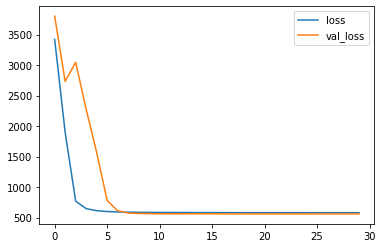

In [ ]:
import pandas as pd
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [ ]:
# Generate predictions for all images in the validation set
test_gen = Washer(1, img_size, test_path)
test_preds = model.predict(test_gen)

## Predict the Results
## 結果を予測する

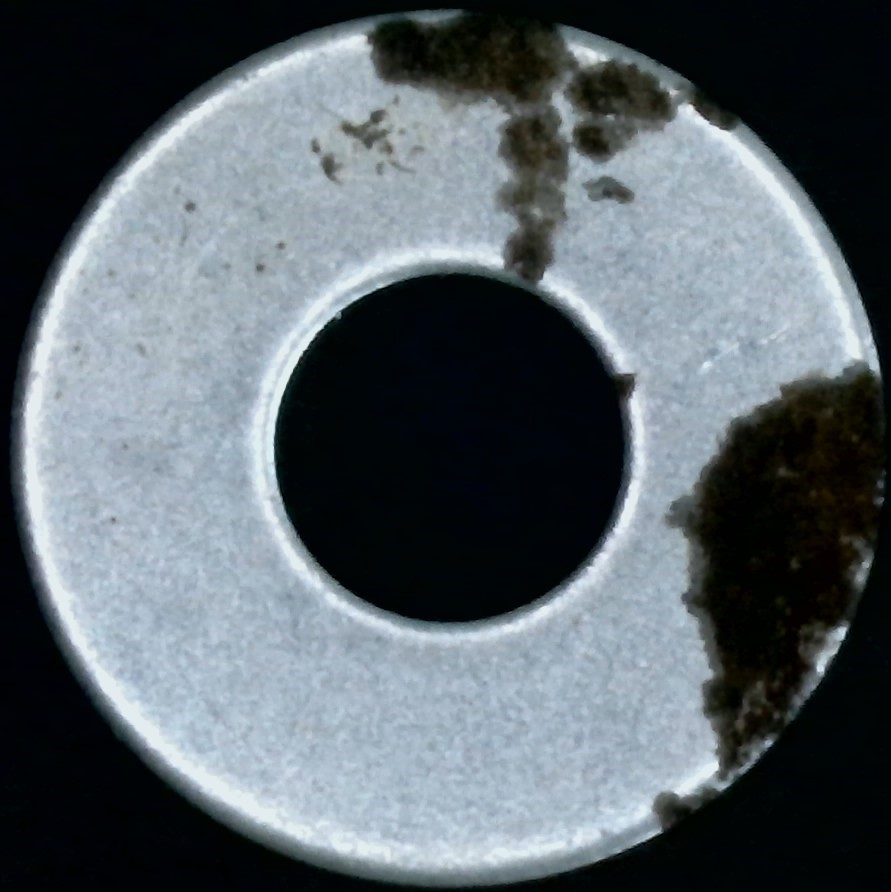

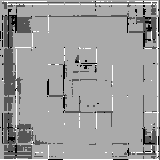

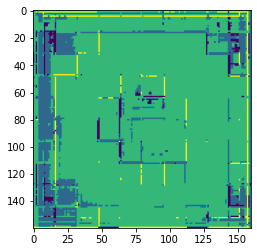

In [ ]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(test_preds[i], axis=-1)
    plt.imshow(mask)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 4

# Display input image
display(Image(filename=test_path[i], width=256, height=256))


# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.